In [1]:
import numpy as np
import torch
import torch.cuda
import random
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import AutoTokenizer, T5Tokenizer, T5ForConditionalGeneration,AutoModelForMaskedLM
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, confusion_matrix,
    roc_curve, auc, matthews_corrcoef
)

/home2/autotune_vits/miniconda3/envs/nlp_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(torch.cuda.get_device_name(0))

cuda
NVIDIA GeForce RTX 2080 Ti


In [3]:
def read_csv_file_input(file_path):
    data = []
    with open(file_path, 'r',encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if len(row['input']) < 100 :
                data.append(row['input'])
            if len(data) >= 100000:
                break
    return data

def read_csv_file_output(file_path):
    data = []
    with open(file_path, 'r', encoding='utf-8') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            # Check if 'output' is not NULL (not an empty string or None)
            if row['output'] and len(row['output']) < 100:
                data.append(row['output'])
            if len(data) >= 100000:
                break
    return data

def evaluate_perplexity(curr_sentence,rb_model,Tokenizer):

    encoded_sentence = Tokenizer.encode(curr_sentence,return_tensors = 'pt').to(device)

    dim = encoded_sentence.size(-1) - 1 # removing start and end
    final_encoded = encoded_sentence.repeat(dim-1,1).to(device)


    mask_tensor = torch.ones(dim).to(device)

    mask_tensor = mask_tensor.diag(1)[:-2]

    mask_tensor = final_encoded.masked_fill(mask_tensor == 1,Tokenizer.mask_token_id)

    labels = final_encoded.masked_fill(mask_tensor != Tokenizer.mask_token_id,-100)

    with torch.no_grad():
        outputs = rb_model(input_ids=mask_tensor, labels=labels)
        loss = outputs.loss

    # Calculate and return perplexity
    perplexity = np.exp(loss.item())
    return perplexity


In [4]:
Model_name = 'roberta-base'

#using a pre-trained tokenizer
Tokenizer = AutoTokenizer.from_pretrained(Model_name)

rb_model =  AutoModelForMaskedLM.from_pretrained(Model_name).to(device)

file_path = './C4_200M_1M.csv'
data = read_csv_file_input(file_path)
print(len(data))

100000


In [5]:
results = []

for i in tqdm(range(0, len(data)), desc="Progress Bar"):
    perp = evaluate_perplexity(curr_sentence=data[i], rb_model=rb_model, Tokenizer=Tokenizer)

    results.append(perp)

results = np.array(results)

print("Mean Perplexity Input:", np.mean(results))
print("Median Perplexity Input:", np.median(results))

Progress Bar: 100%|██████████| 100000/100000 [22:06<00:00, 75.37it/s]

Mean Perplexity Input: 594.5946261854657
Median Perplexity Input: 55.35531755902507


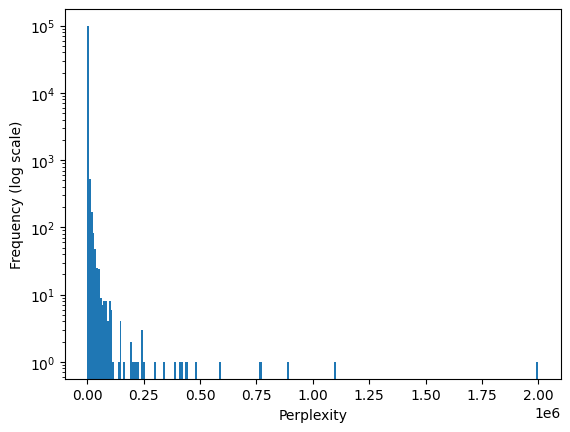

In [6]:
# Plot histogram of perplexity scores
plt.hist(results, bins=250, log=True)
plt.xlabel("Perplexity")
plt.ylabel("Frequency (log scale)")
plt.savefig("Transformer-input-wrong.png")
plt.show()

In [4]:
Model_name = 'roberta-base'

#using a pre-trained tokenizer
Tokenizer = AutoTokenizer.from_pretrained(Model_name)

rb_model =  AutoModelForMaskedLM.from_pretrained(Model_name).to(device)

file_path = './C4_200M_1M.csv'
data = read_csv_file_output(file_path)
print(len(data))

100000


In [5]:
results = []

for i in tqdm(range(0, len(data)), desc="Progress Bar"):
    perp = evaluate_perplexity(curr_sentence=data[i], rb_model=rb_model, Tokenizer=Tokenizer)

    results.append(perp)

results = np.array(results)

print("Mean Perplexity Output:", np.mean(results))
print("Median Perplexity Output:", np.median(results))

Progress Bar: 100%|██████████| 100000/100000 [22:07<00:00, 75.33it/s]

Mean Perplexity Output: 102.45619526111389
Median Perplexity Output: 10.108536263758932


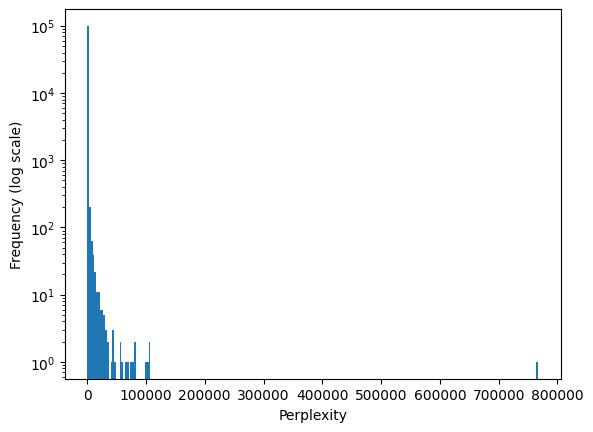

In [6]:
# Plot histogram of perplexity scores
plt.hist(results, bins=250, log=True)
plt.xlabel("Perplexity")
plt.ylabel("Frequency (log scale)")
plt.savefig("Transformer-output-correct.png")
plt.show()

## Binary Classification Task

In [5]:
output_sentences = read_csv_file_output(file_path)
test_sentences = read_csv_file_input(file_path)

In [6]:
# Take a mix of output and test sentences for binary classification task
## Take 10k output sentences and 10k test sentences randomly
output_sentences_bc = random.sample(output_sentences, 10000)
test_sentences_bc = random.sample(test_sentences, 10000)

# Create a binary classification dataset
binary_classification_dataset = output_sentences_bc + test_sentences_bc
binary_classification_labels = [1] * 10000 + [0] * 10000


In [7]:
class PerplexityDataset(Dataset):
    def __init__(self, sentences, labels, perplexity_function):
        self.sentences = sentences
        self.labels = labels
        self.perplexity_function = perplexity_function

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        sentence = self.sentences[idx]
        label = self.labels[idx]
        perplexity_score = self.perplexity_function(sentence)
        return torch.tensor([perplexity_score], dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [8]:
# Create train and test loaders for the binary classification task
train_sentences, test_sentences, train_labels, test_labels = train_test_split(binary_classification_dataset, binary_classification_labels, test_size=0.2, random_state=42)

train_dataset = PerplexityDataset(train_sentences, train_labels, lambda x: evaluate_perplexity(curr_sentence=x, rb_model=rb_model, Tokenizer=Tokenizer))
test_dataset = PerplexityDataset(test_sentences, test_labels, lambda x: evaluate_perplexity(curr_sentence=x, rb_model=rb_model, Tokenizer=Tokenizer))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [9]:
class PerplexityClassifier(nn.Module):
    def __init__(self):
        super(PerplexityClassifier, self).__init__()
        self.classifier = nn.Linear(1, 2)

    def forward(self, x):
        return self.classifier(x)

In [10]:
# Hyperparameters
learning_rate = 0.01
num_epochs = 10

# Initialize the model
classifier = PerplexityClassifier().to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(classifier.parameters(), lr=learning_rate)

In [11]:
def train_classifier(model, train_loader, criterion, optimizer, num_epochs=5):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")

In [12]:
# Call the training function
train_classifier(classifier, train_loader, criterion, optimizer, num_epochs)

Epoch 1/10, Loss: 9.3336
Epoch 2/10, Loss: 2.9835
Epoch 3/10, Loss: 3.9548
Epoch 4/10, Loss: 1.3886
Epoch 5/10, Loss: 1.0893
Epoch 6/10, Loss: 1.2245
Epoch 7/10, Loss: 1.0347
Epoch 8/10, Loss: 1.9796
Epoch 9/10, Loss: 2.9883
Epoch 10/10, Loss: 12.6122


In [13]:
def test(model, test_loader, criterion):
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []
    all_probs = []
    total_loss = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(outputs[:, 1].cpu().numpy())

    # Compute Metrics
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='binary')
    precision = precision_score(all_labels, all_preds, average='binary')
    recall = recall_score(all_labels, all_preds, average='binary')
    mcc = matthews_corrcoef(all_labels, all_preds)
    conf_matrix = confusion_matrix(all_labels, all_preds)

    # ROC Curve and AUC
    fpr, tpr, _ = roc_curve(all_labels, all_probs)
    roc_auc = auc(fpr, tpr)

    print(f"Validation Loss: {total_loss / len(test_loader):.4f}")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"F1 Score: {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"Matthews Correlation Coefficient: {mcc:.4f}")
    print(f"Confusion Matrix:\n{conf_matrix}")
    print(f"AUC: {roc_auc:.4f}")

    # Plot ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

Validation Loss: 8.7780
Accuracy: 71.40%
F1 Score: 0.7245
Precision: 0.7051
Recall: 0.7449
Matthews Correlation Coefficient: 0.4283
Confusion Matrix:
[[1352  629]
 [ 515 1504]]
AUC: 0.7846


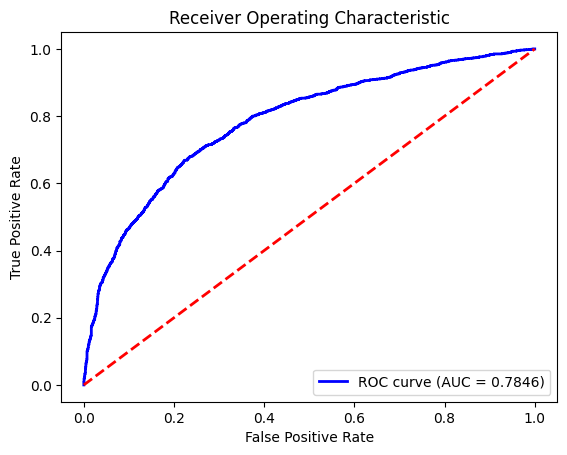

In [14]:
# Call the test function
test(classifier, test_loader, criterion)